In [72]:
import json
import jsonlines
import numpy as np
import tqdm
from tqdm import tqdm
import numpy as np
from dawid_skene import dawid_skene
import json
from collections import defaultdict
from sklearn.cluster import SpectralClustering

In [73]:
def p(r, c):
    R, C = np.shape(adjacency_matrix)

    if np.isnan(adjacency_matrix[r, c]):
        adjacency_matrix[r, c] = sum(p(r, k) * p(k, c) for k in range(C))

    return adjacency_matrix[r, c]

In [74]:
def complete(adjacency_matrix):
    R, C = np.shape(adjacency_matrix)
    ## For each nan entry (r, c), fill it in with sum(p(r, k) * p(k, c) for all r -> k)

    for r in range(R):
        for c in range(C):
            
            if not np.isnan(adjacency_matrix[r, c]):
                continue
            
            adjacency_matrix[r, c] = p(r, c)
    
    return adjacency_matrix

In [75]:
with open("/Users/karthikeyansaravanan/Downloads/drive-download-20230720T205545Z-001/6_28_2023 Anonymized Theme Versions.json", "r") as f:
    theme_versions = json.load(f)

In [76]:
with jsonlines.open("/Users/karthikeyansaravanan/Downloads/drive-download-20230720T205545Z-001/6_28_2023 TLD Export.json", "r") as reader:
    tlds = [line for line in reader]

In [77]:
annotations = []

In [78]:
with jsonlines.open("/Users/karthikeyansaravanan/Downloads/drive-download-20230720T205545Z-001/6_28_2023 Anonymized Annotations.jsonl", "r") as reader:
    for line in reader:
        annotations.append(line)

In [79]:
id_to_ann = {ann["u__id"]: ann for ann in annotations}

In [80]:
sentence_prediction = []
with jsonlines.open("/Users/karthikeyansaravanan/Downloads/drive-download-20230720T205545Z-001/7_3_2023 Sentence Predictions.jsonl", "r") as reader:
    for line in reader:
        sentence_prediction.append(line)

In [81]:
# Research Question ID
research_question_id = "jfRAo4TJxJ3BIRBkh25T"

In [82]:
theme_versions = list(filter(lambda theme_version: theme_version["u__authorId"] != "DEFAULT" and theme_version["u__researchQuestionId"] == research_question_id, theme_versions))

In [83]:
# Filter relevant sentences based on the research question ID
relevant_sentences = set() ## CHANGED THIS TO A SET, BECAUSE DUE TO SOME ISSUES SOMETIMES CONSECUTIVE SENTENCEPREDICTIONS HIGHLIGHT THE SAME SENTENCE (but always with the same value of isRelevant, which was causing duplicates)
for entry in sentence_prediction:
    if entry['u__researchQuestionId'] == research_question_id:
        transcript_id = entry['u__transcriptId']
        sentence_chunks = entry['u_sentenceChunks']
        relevant_pairs = set() ## SAME REASON AS ABOVE
        for chunk in sentence_chunks:
            is_relevant = chunk.get('isRelevant', False)
            if is_relevant:
                start_line = int(chunk['start'])
                end_line = int(chunk['end'])
                for line in range(start_line, end_line + 1):
                   relevant_pairs.add((transcript_id, line))

        relevant_sentences = relevant_sentences.union(relevant_pairs)

relevant_sentences = list(relevant_sentences)

In [84]:
# Assign an index to each pair of sentences
sentence_index = {}
index = 0
for i1 in range(len(relevant_sentences)):
    sent1 = relevant_sentences[i1]
    for i2 in range(i1 + 1, len(relevant_sentences)):
        sent2 = relevant_sentences[i2]
        sentence_index[(sent1, sent2)] = index
        sentence_index[(sent2, sent1)] = index
        index += 1

In [85]:
# Get the unique author IDs from theme versions
author_ids = set(theme_version['u__authorId'] for theme_version in theme_versions)

In [86]:
# Create the annotator index
author_index = {author_id: i for i, author_id in enumerate(author_ids)}

In [87]:
# Calculate the number of relevant sentences
n = len(relevant_sentences)

In [88]:
# Calculate the number of pairs
I = len(sentence_index)
assert I == n * (n - 1), (I, n * (n - 1)) ## THIS WAS NOT PASSING BEFORE, AS THERE WERE DUPLICATE LINES IN RELEVANT SENTENCES

In [89]:
print("Graph will have at most", n, "nodes and at most", I, "edges")

Graph will have at most 687 nodes and at most 471282 edges


In [90]:
J = 2
K = len(author_ids)

In [91]:
# Initialize the N matrix
N = np.array([[[0 for _ in range(K)] for _ in range(J)] for _ in range(I)])

In [92]:
# Process theme versions and annotations
for theme_version_index in tqdm(range(len(theme_versions))):
    theme_version = theme_versions[theme_version_index]
    # Store all annotations for this themeVersion, as well as which theme each one is assigned to.
    tv_annotations = []
    annotation_to_theme = dict()

    for theme_index, theme in enumerate(theme_version["structure"]):
        # Store all annotations from this theme and its subthemes for this themeVersion:
        tv_annotations += theme["u__annotationIds"]
        for subtheme in theme["children"]:
            tv_annotations += subtheme["u__annotationIds"]

            # Assign all annotations from this theme and its subthemes to this theme:
            for ann in theme["u__annotationIds"]:
                annotation_to_theme[ann] = theme_index

            for subtheme in theme["children"]:
                for ann in subtheme["u__annotationIds"]:
                    annotation_to_theme[ann] = theme_index

    # Iterate through all tv_annotations (including tv_ann_1_id)
    for tv_ann_1_id in tv_annotations:
        # Skip if id not in id_to_ann
        if tv_ann_1_id not in id_to_ann:
            continue

        # Get the annotation tv_ann_1 from id_to_ann
        tv_ann_1 = id_to_ann[tv_ann_1_id]

        # Access the startLine and endLine from _indices and convert them to int
        start_line_tv_ann_1 = int(tv_ann_1["u_indices"]["startLine"])
        end_line_tv_ann_1 = int(tv_ann_1["u_indices"]["endLine"])

        # Iterate through all tv_annotations (including tv_ann_1_id) again
        for tv_ann_2_id in tv_annotations:
            # Skip if id not in id_to_ann
            if tv_ann_2_id not in id_to_ann:
                continue

            # Get the annotation tv_ann_2 from id_to_ann
            tv_ann_2 = id_to_ann[tv_ann_2_id]

            # Access the startLine and endLine from _indices and convert them to int
            start_line_tv_ann_2 = int(tv_ann_2["u_indices"]["startLine"])
            end_line_tv_ann_2 = int(tv_ann_2["u_indices"]["endLine"])

            # Iterate through all lines highlighted by annotation tv_ann_1
            for line_tv_ann_1 in range(start_line_tv_ann_1, end_line_tv_ann_1 + 1):
                # Iterate through all lines highlighted by annotation tv_ann_2
                for line_tv_ann_2 in range(start_line_tv_ann_2, end_line_tv_ann_2 + 1):
                    # Skip if they're the same
                    if line_tv_ann_1 == line_tv_ann_2:
                        continue
                        

                    # Find i (the sentence index for this pair of lines from the two loops)
                    pair_x = (tv_ann_1["u__transcriptId"], line_tv_ann_1)
                    pair_y = (tv_ann_2["u__transcriptId"], line_tv_ann_2)
                    if pair_x not in relevant_sentences or pair_y not in relevant_sentences:
                        continue
                    i = sentence_index[(pair_x, pair_y)]

                    # Find k (the author index of the person who created this themeVersion)
                    k = author_index.get(theme_version["u__authorId"], -1)

                    # If tv_ann_1 and tv_ann_2 are in the same theme, set N[i][1][k] = 1, else set N[i][0][k] = 1
                    theme_tv_ann_1 = annotation_to_theme.get(tv_ann_1_id)
                    theme_tv_ann_2 = annotation_to_theme.get(tv_ann_2_id)
                    if theme_tv_ann_1 and theme_tv_ann_2 and theme_tv_ann_1 == theme_tv_ann_2:
                        N[i][1][k] += 1
                    else:
                        N[i][0][k] += 1

100%|███████████████████████████████████████████| 55/55 [03:04<00:00,  3.35s/it]


In [93]:
# This assertion should pass, indicating that you have filled in some entries
assert np.sum(N) != 0

In [94]:
# Find pairs of sentences with zero labels and get their indices
zero_labels_indices = set(np.where(np.sum(N, axis=(1, 2)) == 0)[0])

print("Number of pairs with zero labels:", len(zero_labels_indices))

Number of pairs with zero labels: 286790


In [95]:
# Create a mapping for sentence index without zero labels
# Maps from previous sentence index to updated index
updated_sentence_index = {}
updated_index = 0

for i in range(I):
    # If row i has labels, the next entry in the updated_sentence_index is given to it. Else, the row will not be a key in the updated_sent_index at all.
    if i not in zero_labels_indices:
        updated_sentence_index[i] = updated_index
        updated_index += 1

In [96]:
# Filter rows with zero labels and update sentence_index
N = N[list(updated_sentence_index.keys())]
# sentence_index: (sentence pair) => updated row if the sentence pair had labels
sentence_index = {k: updated_sentence_index[v] for k, v in sentence_index.items() if v not in zero_labels_indices}

In [97]:
# Call the dawid_skene function with the updated 3D array N
predictions = dawid_skene(N)

In [98]:
# Get the pairs of sentences predicted to be similar and different
similar_pairs = []
different_pairs = []

In [99]:
# Load the TLD Export JSON
with jsonlines.open("/Users/karthikeyansaravanan/Downloads/drive-download-20230720T205545Z-001/6_28_2023 TLD Export.json", "r") as tld_reader:
    tld_export = list(tld_reader)

In [100]:
# Create a dictionary to store lines for each transcript
transcript_lines = {(transcriptL["u__transcriptId"], int(line["u__lineNumber"])): line["text"] for transcriptL in tld_export for line in transcriptL["lines"]}

In [101]:
# Get the pairs of sentences predicted to be similar and different
similar_pairs = []
different_pairs = []

In [102]:
# Reverse the sentence_index dictionary
reversed_sentence_index = {v: k for k, v in sentence_index.items()}

updated_relevant_sentences = set()

In [103]:
# Create a new list to store updated relevant sentences
for sent_pair in sentence_index.keys():
    x, y = sent_pair
    updated_relevant_sentences.add(x)
    updated_relevant_sentences.add(y)

updated_relevant_sentences = list(updated_relevant_sentences)
sentence_to_row = {sent: row for row, sent in enumerate(updated_relevant_sentences)}
nodes = len(updated_relevant_sentences)

In [104]:
## Generate Adjacency Matrix
## Should be n x n
## Should be all NaNs initially, then fill in each edge we know
import numpy as np
adjacency_matrix = np.ones((nodes, nodes))
adjacency_matrix.fill(np.nan)

for sent_pair, index in sentence_index.items():
    x, y = sent_pair
    adjacency_matrix[sentence_to_row[x], sentence_to_row[y]] = predictions[index]

## Complete Adjacency Matrix
## Display results

In [110]:
import numpy as np

# Assuming you already have the `adjacency_matrix` filled with NaNs and the `predictions` array

# Compute the mean of each row (ignoring NaNs)
row_means = np.nanmean(adjacency_matrix, axis=1)

# Get the indices of NaN values in the adjacency_matrix
nan_indices = np.isnan(adjacency_matrix)

# Replace NaN values with row means
adjacency_matrix[nan_indices] = np.take(row_means, np.where(nan_indices)[0])

# Display the completed adjacency matrix
print("Completed Adjacency Matrix:")
print(adjacency_matrix)

Completed Adjacency Matrix:
[[0.58305648 1.         0.         ... 1.         1.         0.        ]
 [1.         0.54605263 0.         ... 1.         1.         0.        ]
 [0.         0.         0.00166667 ... 0.         0.         0.        ]
 ...
 [1.         1.         0.         ... 0.59605911 1.         0.        ]
 [1.         1.         0.         ... 1.         0.59210526 0.        ]
 [0.         0.         0.         ... 0.         0.         0.04590164]]


In [120]:
import numpy as np
import networkx as nx
import community

# Assuming you already have the `adjacency_matrix` filled with values and the `nodes` variable defined.

# Convert the adjacency matrix to a networkx graph
G = nx.from_numpy_matrix(adjacency_matrix)

# Run the Louvain method to detect communities
partition = community.best_partition(G)

# Set a random seed for reproducibility
np.random.seed(42)

# Print the clusters
clusters = {}
for node, cluster_id in partition.items():
    if cluster_id not in clusters:
        clusters[cluster_id] = [node]
    else:
        clusters[cluster_id].append(node)

print("Clusters:")
for cluster_id, nodes in clusters.items():
    print(f"Cluster {cluster_id}: {nodes}")

Clusters:
Cluster 0: [0, 1, 6, 8, 12, 14, 15, 16, 17, 22, 23, 24, 27, 28, 29, 31, 34, 37, 39, 40, 42, 44, 46, 54, 55, 56, 61, 69, 72, 73, 76, 77, 83, 85, 86, 87, 92, 94, 96, 97, 101, 102, 106, 107, 109, 112, 114, 115, 119, 122, 123, 125, 130, 131, 134, 139, 145, 150, 151, 152, 156, 164, 165, 167, 168, 169, 171, 174, 175, 185, 190, 193, 199, 204, 209, 223, 224, 228, 235, 237, 247, 252, 253, 255, 256, 260, 261, 264, 273, 274, 276, 277, 281, 282, 283, 286, 288, 290, 293, 296, 297, 299, 300, 305, 306, 311, 312, 313, 318, 322, 324, 330, 331, 334, 336, 337, 339, 340, 342, 344, 346, 349, 350, 353, 356, 358, 359, 362, 363, 364, 366, 369, 371, 376, 377, 378, 382, 384, 385, 388, 389, 392, 393, 397, 400, 404, 407, 411, 413, 414, 417, 426, 429, 430, 432, 434, 436, 440, 442, 443, 444, 445, 454, 460, 462, 464, 465, 467, 469, 472, 473, 475, 486, 487, 489, 490, 495, 498, 501, 502, 516, 524, 525, 529, 532, 535, 536, 544, 548, 549, 552, 558, 571, 572, 574, 576, 579, 582, 584, 587, 589, 595, 597, 598, 60

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

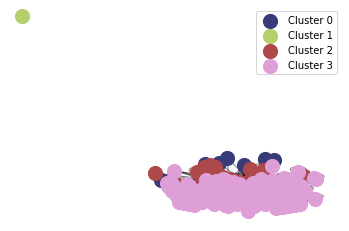

In [121]:
import numpy as np
import networkx as nx
import community
import matplotlib.pyplot as plt

# Assuming you already have the `adjacency_matrix` filled with values and the `nodes` variable defined.

# Convert the adjacency matrix to a networkx graph
G = nx.from_numpy_matrix(adjacency_matrix)

# Run the Louvain method to detect communities
partition = community.best_partition(G)

# Set a random seed for reproducibility
np.random.seed(42)

# Create a list of colors for each cluster
num_clusters = max(partition.values()) + 1
colors = plt.cm.tab20b(np.linspace(0, 1, num_clusters))

# Draw the graph with different colors for each cluster
pos = nx.spring_layout(G)  # You can use other layout algorithms as well
for cluster_id, color in zip(range(num_clusters), colors):
    nodes = [node for node in partition.keys() if partition[node] == cluster_id]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=200, label=f"Cluster {cluster_id}")

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.legend(loc="best")
plt.axis('off')
plt.show()

In [115]:
# Print sentences corresponding to each cluster
for cluster in range(num_clusters):
    cluster_nodes = [node for node in G.nodes() if partition[node] == cluster]
    print(f"Cluster {cluster}:")
    for node in cluster_nodes:
        pair = relevant_sentences[node]
        
        text_x = transcript_lines[(pair[0][0], (pair[0][1]))]
        text_y = transcript_lines[(pair[1][0], (pair[1][1]))]
        print(f"Pair: {text_x} | {text_y}")
    print("\n")

Cluster 0:


KeyError: ('E', 'R')